# Multiple Currency SMA Crossover (Hourly)
This strategy demonstrates a simple SMA crossover trading two different assets (BTC, ETH)
 
#### Strategy Logic
- **Buy Entry (Golden Cross)**: When the 20-SMA crosses **above** the 50-SMA
- **Sell Exit (Death Cross)**: When the 20-SMA crosses **below** the 50-SMA
- **Asset Allocation**: 50% BTC 50% ETH

### Before we begin, we need to load the data (OHLCV) and process the indicator

In [1]:
import pandas as pd
from typing import Dict
from overfitting import Strategy

In [2]:
# Constants
DATA_PATHS={
    "BTC": "./data/BTCUSDT.csv",
    "ETH": "./data/ETHUSDT.csv"
}
START_TIME="2023-01-01 00:00:00"
END_TIME="2024-08-29 00:00:00"

In [3]:
def load_data(data_path: Dict, start_time, end_time) -> Dict[str, pd.DataFrame]:
    
    data: Dict[str, pd.DataFrame] = {}
    
    for asset, path in data_path.items(): 
        df = pd.read_csv(path)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.drop(columns=["volume"], axis=1)
        
        # Currently for every symbols timestamps has to be identical
        start_time = pd.to_datetime(start_time)
        end_Time = pd.to_datetime(end_time)
        df = df.loc[start_time:end_Time]

        # Compute short and long SMAs
        df['sma_short'] = df['close'].rolling(window=20).mean().shift(1)
        df['sma_long'] = df['close'].rolling(window=50).mean().shift(1)

        data[asset] = df
    
    return data

backtest_data = load_data(DATA_PATHS, START_TIME, END_TIME)
print(backtest_data['ETH'].head())


                        open     high      low    close  sma_short  sma_long
timestamp                                                                   
2023-01-01 00:00:00  1196.10  1196.85  1192.29  1193.89        NaN       NaN
2023-01-01 01:00:00  1193.89  1196.71  1193.76  1196.16        NaN       NaN
2023-01-01 02:00:00  1196.16  1196.98  1193.99  1195.62        NaN       NaN
2023-01-01 03:00:00  1195.61  1195.61  1191.36  1194.05        NaN       NaN
2023-01-01 04:00:00  1194.05  1194.08  1190.80  1193.07        NaN       NaN


In [4]:
class MyStrategy(Strategy):
    def init(self):
        self.universe = ['BTC', 'ETH']
        # Set Every symbol leverage to 1
        for asset in self.universe:
            self.set_leverage(asset, 1)

    def next(self, i):
        for asset in self.universe:
            if i == 0:
                return

            sma_short = self.val(asset, i, "sma_short")
            sma_long = self.val(asset, i, "sma_long")
            previous_sma_short = self.val(asset, i - 1, "sma_short") 
            previous_sma_long = self.val(asset, i - 1, "sma_long")

            # Also skip if values are not available
            if (pd.isna(sma_short) or pd.isna(sma_long) or 
                pd.isna(previous_sma_short) or pd.isna(previous_sma_long)):
                return

            # Fetch the current position
            position = self.get_position(asset)

            # Golden cross (entry)
            if previous_sma_short <= previous_sma_long and sma_short > sma_long and position.qty == 0:
                # First fetch current open price which is the target Price
                open_price = self.open(asset, i)
                # Determine Lot Size - 50% BTC 50% ETH
                lot_size = (self.get_balance() / 2) // open_price
                # Create LIMIT ORDER
                self.limit_order(asset, lot_size, open_price)

            # Death cross (exit)
            if previous_sma_short >= previous_sma_long and sma_short < sma_long and position.qty > 0:
                self.market_order(asset, -position.qty)


Performance Summary
Number of Years               1.66000000
Start Date           2023-01-01 00:00:00
End Date             2024-08-29 00:00:00
Initial Balance         100,000.00000000
Final Balance           171,805.58081600
CAGR                          0.38536863
Cumulative Return             1.71805581
Sharpe Ratio                  1.21476209
Sortino Ratio                 2.95052191
Max Drawdown                 -0.17482402
Daily Value At Risk          -0.03086780
Skew                          0.32103743
Kurtosis                      2.60975289
Total Trades                349.00000000
Winning Trades              124.00000000
Losing Trades               225.00000000
Win Rate (%)                 35.53008596
Gross Profit            301,459.57141800
Gross Loss             -229,653.99060200
Net Profit               71,805.58081600
Avg Return (%)                0.32382399
Avg Profit (%)                3.73137916
Avg Loss (%)                 -1.55411752
  Net drawdown in %  Peak date Valley

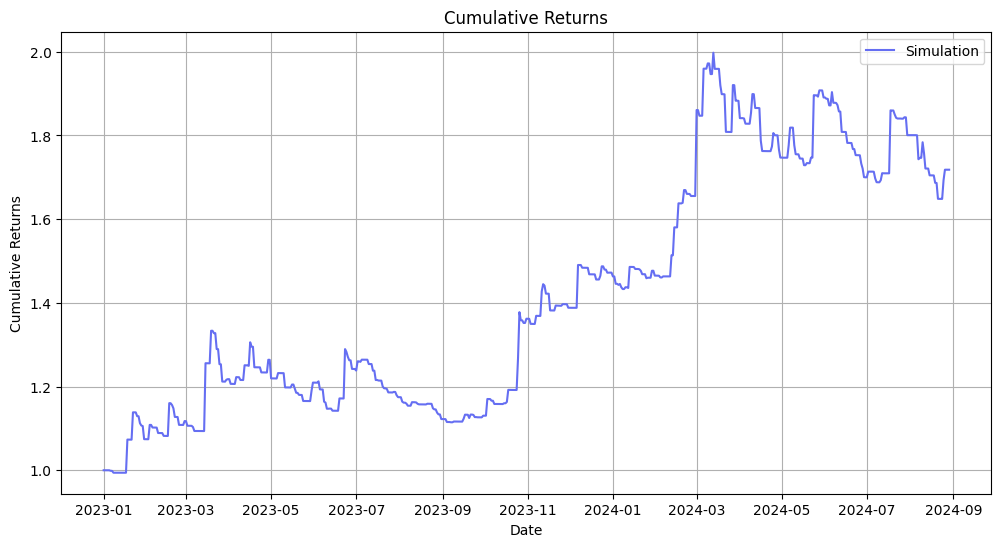

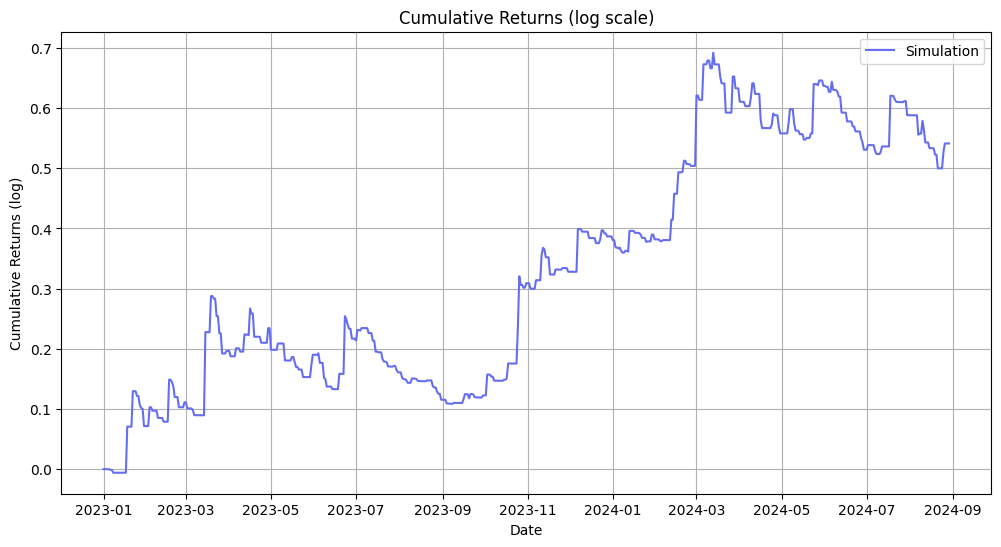

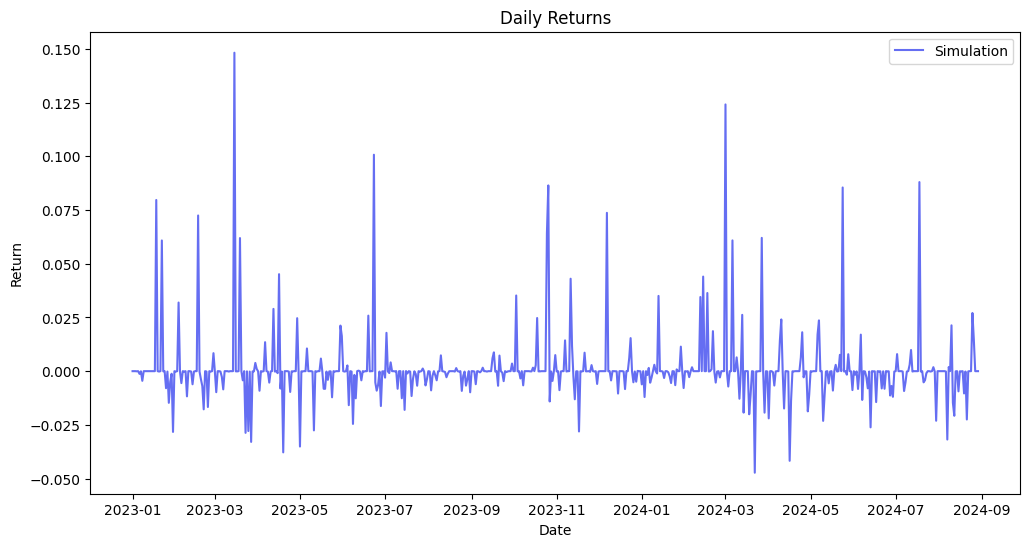

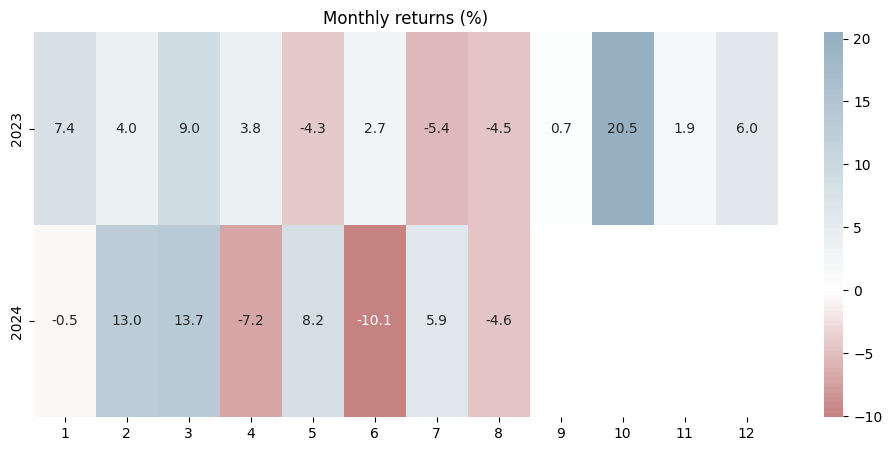

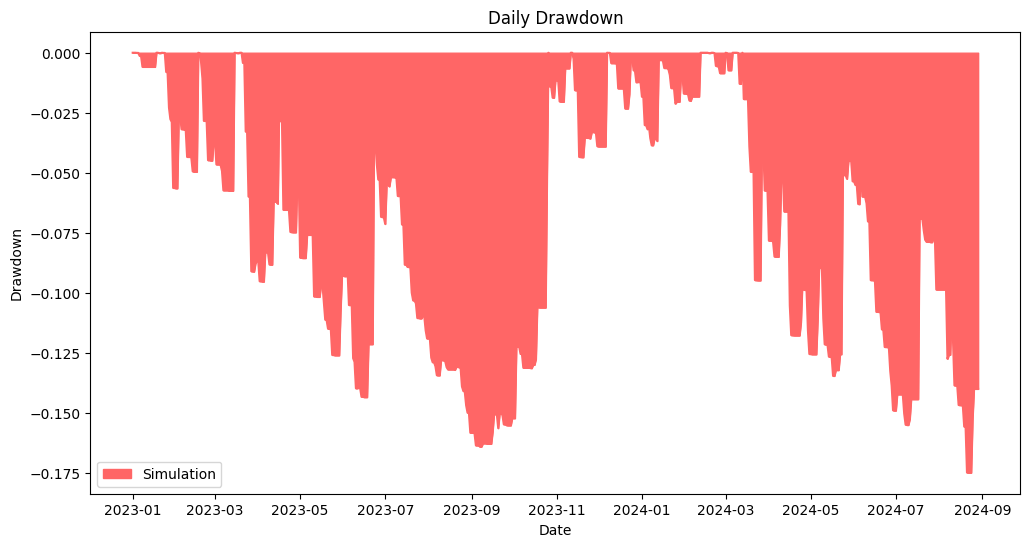

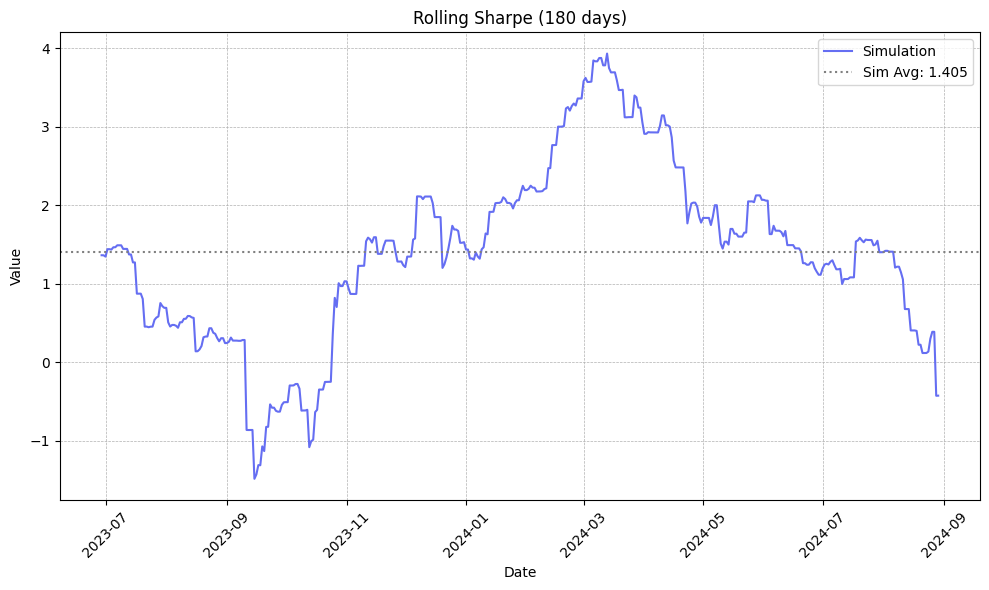

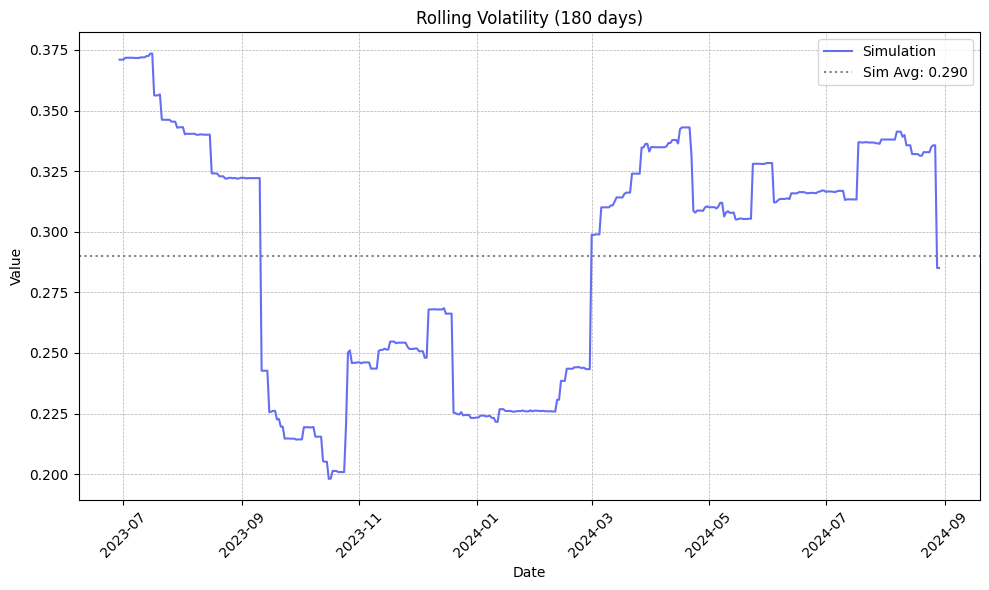

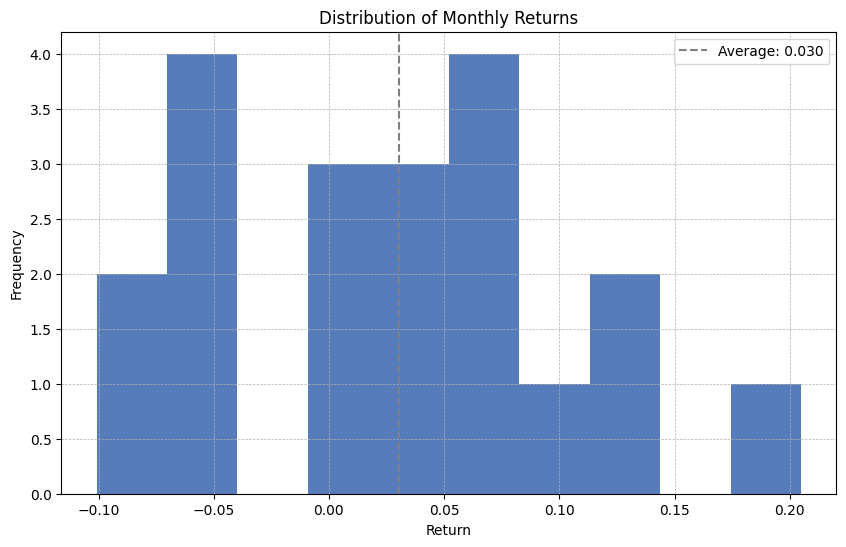

In [5]:
strategy = MyStrategy(data=backtest_data)
returns = strategy.run()
strategy.plot(returns)

In [6]:
strategy.fetch_trades()

,id,created_at,symbol,qty,price,type,status,stop_price,is_triggered,reason,executed_price,commission,pnl,realized_pnl
0,7fec4bbd264f4876,2023-01-04 07:00:00,BTC,2.0,16872.80,LIMIT,FILLED,None,False,None,16872.80,6.749120,0.00,-6.749120
1,b9f6c79aabec42d0,2023-01-06 02:00:00,BTC,-2.0,16818.10,MARKET,FILLED,None,False,None,16818.10,6.727240,-109.40,-116.127240
2,d68119bb7c334ca4,2023-01-06 20:00:00,ETH,39.0,1272.77,LIMIT,FILLED,None,False,None,1272.77,9.927606,0.00,-9.927606
3,57bc35e996504aaf,2023-01-07 01:00:00,BTC,2.0,16969.90,LIMIT,FILLED,None,False,None,16969.90,6.787960,0.00,-6.787960
4,767073ec9c894e26,2023-01-08 13:00:00,ETH,-39.0,1261.53,MARKET,FILLED,None,False,None,1261.53,9.839934,-438.36,-448.199934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,5159fe6d57a5466b,2024-08-22 06:00:00,ETH,31.0,2618.43,LIMIT,FILLED,None,False,None,2618.43,16.234266,0.00,-16.234266
694,ac93aaaf6bce45bd,2024-08-25 19:00:00,ETH,-31.0,2762.90,MARKET,FILLED,None,False,None,2762.90,17.129980,4478.57,4461.440020
695,8002a912a577429a,2024-08-26 02:00:00,BTC,-1.0,63893.30,MARKET,FILLED,None,False,None,63893.30,12.778660,2747.50,2734.721340
696,8704ffb57a434b6c,2024-08-26 03:00:00,BTC,1.0,64033.00,LIMIT,FILLED,None,False,None,64033.00,12.806600,0.00,-12.806600
